Here we will train our model on a sparse prior namely laplace and we aim to see if our neural network is able to pick up on this bimodal nature and correctly select the correct variables.

### Imports

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_probability as tfp
from scipy.stats import mode

tfd = tfp.distributions
tfb = tfp.bijectors

print("Successfully imported all modules")

Successfully imported all modules


In [3]:
no_params = 10
epochs = 200
patience_early_stopping = 10  # Early-stopping window
neurons_per_layer = [128, 128]
dropout_probs = [0.2, 0.2]
always_on_dropout = True  # Keep dropout active at test time

batch_size = 256  # tf.data batch size
theta_range = (0.0, 10.0)
n_per_sample = 1000  # points (x, y) per simulated data-set
noise_std = 0.5
n_examples = 20_000  # simulated data-sets to learn from

# evaluation
no_test_samples = 10_000
mc_samples = 50  # Monte-Carlo dropout passes

In [29]:
def plot_loss(history: tf.keras.callbacks.History,
              title: str = "Loss curve") -> None:
    """Plot training & validation loss curves (linear + semilog-y).
    Generates two stacked panels:
       • top: linear y-axis
       • bottom: semilog-y (base-10) axis """
    epochs = range(1, len(history.history["loss"]) + 1)

    fig, (ax_lin, ax_log) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

    # linear plot
    ax_lin.plot(epochs, history.history["loss"], label="train")
    ax_lin.plot(epochs, history.history["val_loss"], label="val")
    ax_lin.set_ylabel("MSE")
    ax_lin.set_title(title + " (linear scale)")
    ax_lin.legend()
    ax_lin.grid(True, which="both", linestyle="--", linewidth=0.5)

    # semilog-y plot
    ax_log.semilogy(epochs, history.history["loss"], label="train")
    ax_log.semilogy(epochs, history.history["val_loss"], label="val")
    ax_log.set_xlabel("Epoch")
    ax_log.set_ylabel("MSE (log scale)")
    ax_log.set_title(title + " (semilogy)")
    ax_log.legend()
    ax_log.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()


### Define our NN as before

In [4]:
class NN(Model):
    """Two-layer MLP with optional always-on dropout."""

    def __init__(self,
                 no_params: int,
                 neurons: list,
                 dropout_probs: list,
                 always_on_dropout: bool = False):
        super(NN, self).__init__(name='NN')  # inherits the parent class and names it (for debugging)

        self.neurons = neurons
        self.no_params = no_params  # number of parameters we output
        self.always_on_dropout = always_on_dropout  # if true then we leave on for test passes

        # Define our layers - we will loop over creating the required hidden and dropout layers
        self.norm = tf.keras.layers.Normalization(axis=-1, name="input_norm")

        self.hidden_layers = []

        for size, p in zip(neurons, dropout_probs):
            self.hidden_layers.append(tf.keras.layers.Dense(size, activation="relu"))
            self.hidden_layers.append(tf.keras.layers.Dropout(rate=p))

        self.out = Dense(no_params, activation="linear", name="out")  # Applies linear activation

    def call(self,
             inputs: tf.Tensor,
             training: bool = False) -> tf.Tensor:
        """Forward pass with dropout flag logic."""
        dropout_flag = training or self.always_on_dropout

        # Apply our custom layers
        x = self.norm(inputs)
        # every second layer is a Dropout, so we toggle `training` only on those
        for layer in self.hidden_layers:
            if isinstance(layer, tf.keras.layers.Dropout):
                x = layer(x, training=dropout_flag)
            else:
                x = layer(x)
        return self.out(x)


### Create our dataset

First define our laplace prior

In [56]:
def simulate_batch(no_params: int,
                   batch_size: int,
                   n_per_sample: int,
                   noise_std: float):
    """Simulate one batch of (summary, θ, 1) pairs."""
    # Generate our theta, and random points which will be used to form the output variable
    theta = tfd.Laplace(0.0, 1.0).sample([batch_size, no_params, 1])  # (B, D, 1) use our previous function
    X = tf.random.uniform([batch_size, n_per_sample, no_params])  # (B, n, D)

    # Generate noise and then create output variable
    noise = noise_std * tf.random.normal([batch_size, n_per_sample, 1])  # (B, n, 1)
    y = tf.matmul(X, theta) + noise  # (B, n, 1)

    mean_x = tf.reduce_mean(X, axis=1)  # (B, D)
    mean_y = tf.reduce_mean(y, axis=1)  # (B, 1)

    # Center both x and y around their mean
    xc = X - tf.expand_dims(mean_x, 1)
    yc = y - tf.expand_dims(mean_y, 1)

    # Create the covariance matrix for the data, then the covariance between x and y
    cov_x = tf.matmul(xc, xc, transpose_a=True) / n_per_sample  # (B, D, D)
    cov_xy = tf.matmul(xc, yc, transpose_a=True) / n_per_sample  # (B, D, 1)

    summary = tf.concat([
        mean_x,
        mean_y,
        tf.reshape(cov_x, [-1, no_params * no_params]),
        tf.reshape(cov_xy, [-1, no_params]),
    ], axis=-1)  # (B, D² + 2D + 1)

    return summary, theta


def make_dataset_multi_dim(n_examples: int,
                           no_params: int,
                           batch_size: int,
                           noise_std: float) -> tf.data.Dataset:
    """Create a tf.data pipeline emitting un-batched (summary, θ) pairs."""
    steps = n_examples // batch_size
    ds = tf.data.Dataset.range(steps).map(
        lambda _: simulate_batch(no_params,
                                 batch_size,
                                 n_per_sample,
                                 noise_std),
        num_parallel_calls=tf.data.AUTOTUNE
    ).unbatch()
    return ds.prefetch(tf.data.AUTOTUNE)

In [57]:
train_ds = make_dataset_multi_dim(
    n_examples=int(n_examples * 0.9),
    no_params=no_params,
    batch_size=batch_size,
    noise_std=noise_std
)
val_ds = make_dataset_multi_dim(
    n_examples=int(n_examples * 0.1),
    no_params=no_params,
    batch_size=batch_size,
    noise_std=noise_std
)

In [58]:
input_size = no_params ** 2 + 2 * no_params + 1

myNN = NN(neurons=neurons_per_layer,
          no_params=no_params,
          dropout_probs=dropout_probs,
          always_on_dropout=always_on_dropout)

myNN.norm.adapt(train_ds.map(lambda x, y: x))

myNN.compile(loss='mse', optimizer="adam")

2025-06-26 17:23:13.704640: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9891 - val_loss: 1.1140
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9054 - val_loss: 0.5231
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4596 - val_loss: 0.3601
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3321 - val_loss: 0.2811
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2662 - val_loss: 0.2342
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2370 - val_loss: 0.2196
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2132 - val_loss: 0.2057
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2034 - val_loss: 0.1991
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1947 - val_loss: 0.1970
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1951 - val_loss: 0.1900
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1865 - val_loss: 0.1887
Epoch 12/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (Normalization)      │ (None, 121)            │           243 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,499 (392.58 KB)

 Trainable params: 33,418 (130.54 KB)

 Non-trainable params: 243 (976.00 B)

 Optimizer params: 66,838 (261.09 KB)

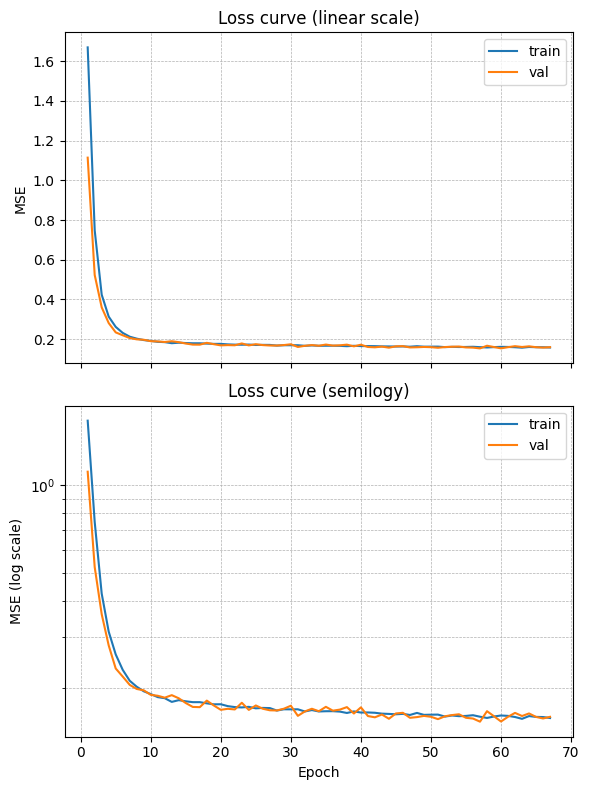

In [59]:
history = myNN.fit(
    train_ds.batch(batch_size),
    validation_data=val_ds.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
myNN.summary()
plot_loss(history)

In [64]:
def average_relative_error(model: tf.keras.Model,
                           batchsize: int,
                           no_tests: int,
                           mc_samples: int,
                           n_per_sample: int,
                           noise_std: float, ) -> float:
    """Estimate mean relative error with Monte-Carlo dropout."""
    # Simulate a fresh batch
    summaries, theta_true = simulate_batch(
        no_params,
        batch_size=no_tests,
        n_per_sample=n_per_sample,
        noise_std=noise_std,
    )  # shapes: (N, ·) and (N, D, 1)
    theta_true_np = np.squeeze(theta_true.numpy(), axis=-1)  # (N, D)

    # Monte-Carlo dropout passes
    preds = [
        model.predict(summaries, batch_size=batchsize, verbose=0)
        for _ in range(mc_samples)
    ]
    theta_pred_mean = tf.reduce_mean(np.stack(preds, axis=0), axis=0)  # (N, D)

    # compute the relative error
    eps = 1e-8
    diff = theta_pred_mean - theta_true_np  # (N, D)
    numer = np.linalg.norm(diff, axis=1)  # ‖θ̂ – θ‖₂
    denom = np.linalg.norm(theta_true_np, axis=1) + eps
    return (numer / denom).mean()


In [66]:
avg_re = average_relative_error(
    model=myNN,
    batchsize=batch_size,
    no_tests=no_test_samples,
    mc_samples=mc_samples,
    n_per_sample=n_per_sample,
    noise_std=noise_std,
)
print(f"Average relative error (MC-{mc_samples}): {avg_re:.4f}")

Average relative error (MC-50): 0.1278


In [69]:
def plot_single_dataset_posterior(model: tf.keras.Model,
                                  *,
                                  no_params: int = no_params,
                                  n_per_sample: int = n_per_sample,
                                  noise_std: float = noise_std,
                                  theta_range: tuple = theta_range,
                                  mc_samples: int = mc_samples,
                                  bins: int = 30,
                                  cmap: str = "tab10") -> None:
    """
    One data-set → many MC-dropout draws → θ histograms
    + overlay of the generative Normal(θ_true, σ²) density.
    The x-axis is fixed to [θ_min - 2,  θ_max + 2]
    """
    # simulate a single experiment  also return raw X, y needed to calculate posterior
    summaries, theta_true = simulate_batch(
        no_params=no_params,
        batch_size=1,
        n_per_sample=n_per_sample,
        noise_std=noise_std,
    )
    theta_true = theta_true.numpy().squeeze(-1).flatten()

    # MC draws
    preds = [
        model.predict(summaries, verbose=0)[0]  # (D,)
        for _ in range(mc_samples)
    ]
    preds = np.stack(preds, axis=0)  # (K, D)

    # set-up plot
    n_rows, n_cols = 2, 5
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 3, n_rows * 3.5),
        squeeze=False
    )

    # for each θ
    for j in range(n_rows * n_cols):
        r, c = divmod(j, n_cols)
        ax = axes[r, c]
        xmin, xmax = -5, 5
        ax.set_xlim(xmin, xmax)

        if j < no_params:
            # histogram of MC–dropout draws
            ax.hist(
                preds[:, j],
                bins=bins,
                color="lightsteelblue",
                edgecolor="k",
                alpha=0.75,
                density=True
            )
            ax.axvline(  # <- was ax.vertical
                theta_true[j],
                color="limegreen",
                linewidth=2.0,
                label=r"$\theta_{\mathrm{true}}$"
            )

            # aesthetics
            ax.set_title(f"θ{j + 1}")
            if c == 0:
                ax.set_ylabel("density")
            ax.grid(alpha=0.3, linestyle="--")
            ax.legend(fontsize=7)
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

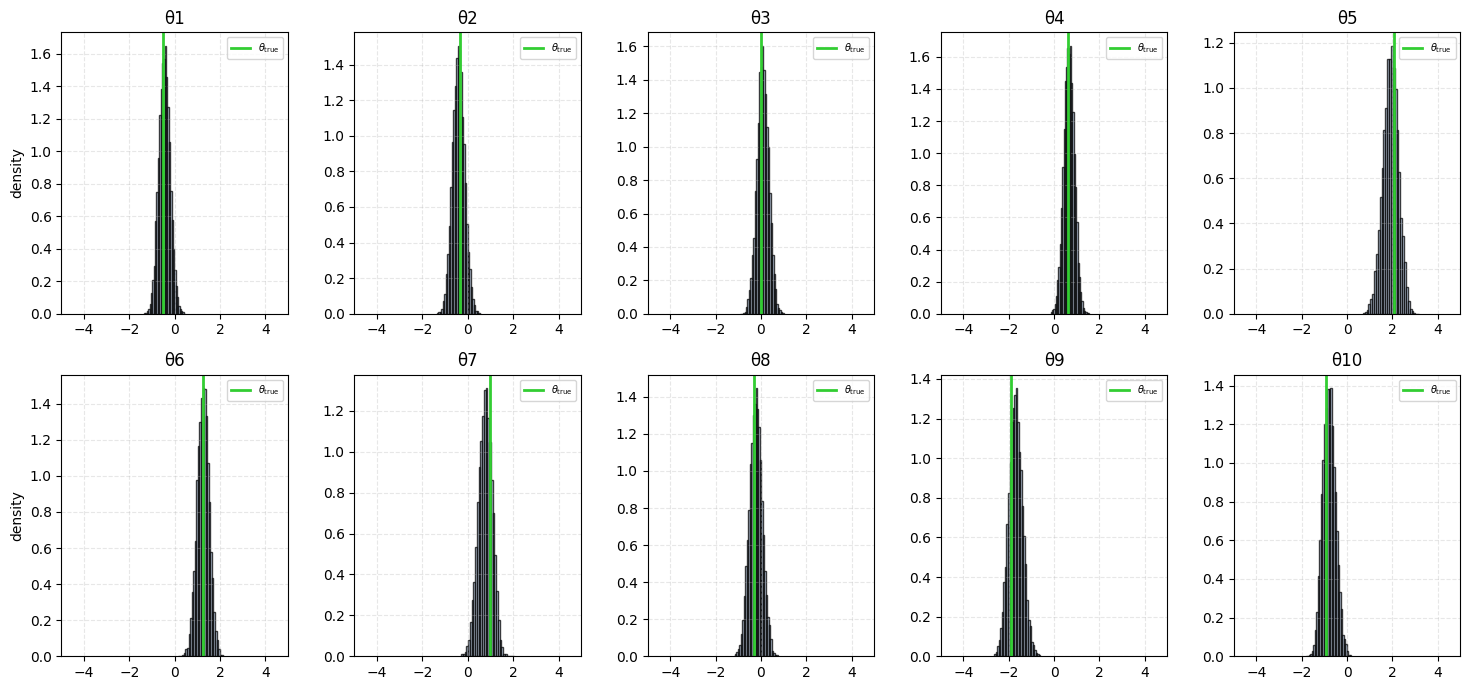

In [70]:
plot_single_dataset_posterior(model=myNN, mc_samples=10_000, noise_std=noise_std)

Spike and normal

In [87]:
def simulate_batch_spike(no_params: int,
                         batch_size: int,
                         n_per_sample: int,
                         noise_std: float,
                         zero_prob: float):
    """Simulate one batch of (summary, θ, 1) pairs."""
    # Generate our theta, and random points which will be used to form the output variable
    theta = tfd.Normal(5, 1.0).sample([batch_size, no_params, 1])  # (B, D, 1) use our previous function

    # Add mask to set some to 0
    keep_prob = 1.0 - zero_prob
    mask = tf.cast(
        tf.less(tf.random.uniform(tf.shape(theta)), keep_prob),
        theta.dtype
    )  # 1 with prob=keep_prob, else 0

    theta = theta * mask

    X = tf.random.uniform([batch_size, n_per_sample, no_params])  # (B, n, D)

    # Generate noise and then create output variable
    noise = noise_std * tf.random.normal([batch_size, n_per_sample, 1])  # (B, n, 1)
    y = tf.matmul(X, theta) + noise  # (B, n, 1)

    mean_x = tf.reduce_mean(X, axis=1)  # (B, D)
    mean_y = tf.reduce_mean(y, axis=1)  # (B, 1)

    # Center both x and y around their mean
    xc = X - tf.expand_dims(mean_x, 1)
    yc = y - tf.expand_dims(mean_y, 1)

    # Create the covariance matrix for the data, then the covariance between x and y
    cov_x = tf.matmul(xc, xc, transpose_a=True) / n_per_sample  # (B, D, D)
    cov_xy = tf.matmul(xc, yc, transpose_a=True) / n_per_sample  # (B, D, 1)

    summary = tf.concat([
        mean_x,
        mean_y,
        tf.reshape(cov_x, [-1, no_params * no_params]),
        tf.reshape(cov_xy, [-1, no_params]),
    ], axis=-1)  # (B, D² + 2D + 1)

    return summary, theta


def make_dataset_multi_dim_spike(n_examples: int,
                           no_params: int,
                           batch_size: int,
                           noise_std: float,
                           zero_prob: float) -> tf.data.Dataset:
    """Create a tf.data pipeline emitting un-batched (summary, θ) pairs."""
    steps = n_examples // batch_size
    ds = tf.data.Dataset.range(steps).map(
        lambda _: simulate_batch_spike(no_params,
                                 batch_size,
                                 n_per_sample,
                                 noise_std,
                                 zero_prob=zero_prob),
        num_parallel_calls=tf.data.AUTOTUNE
    ).unbatch()
    return ds.prefetch(tf.data.AUTOTUNE)

In [88]:
train_ds2 = make_dataset_multi_dim_spike(
    n_examples=int(n_examples * 0.9),
    no_params=no_params,
    batch_size=batch_size,
    noise_std=noise_std,
    zero_prob=0.3
)
val_ds2 = make_dataset_multi_dim_spike(
    n_examples=int(n_examples * 0.1),
    no_params=no_params,
    batch_size=batch_size,
    noise_std=noise_std,
    zero_prob=0.3
)

In [89]:
input_size = no_params ** 2 + 2 * no_params + 1

myNN2 = NN(neurons=neurons_per_layer,
          no_params=no_params,
          dropout_probs=dropout_probs,
          always_on_dropout=always_on_dropout)

myNN2.norm.adapt(train_ds2.map(lambda x, y: x))

myNN2.compile(loss='mse', optimizer="adam")

2025-06-26 18:49:19.272632: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0503 - val_loss: 4.6611
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1029 - val_loss: 2.4270
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0981 - val_loss: 1.5194
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4426 - val_loss: 1.2553
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2115 - val_loss: 1.0914
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0710 - val_loss: 0.9605
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9857 - val_loss: 0.9299
Epoch 8/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9143 - val_loss: 0.8932
Epoch 9/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8659 - val_loss: 0.8487
Epoch 10/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8227 - val_loss: 0.8225
Epoch 11/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8178 - val_loss: 0.7998
Epoch 12/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (Normalization)      │ (None, 121)            │           243 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,499 (392.58 KB)

 Trainable params: 33,418 (130.54 KB)

 Non-trainable params: 243 (976.00 B)

 Optimizer params: 66,838 (261.09 KB)

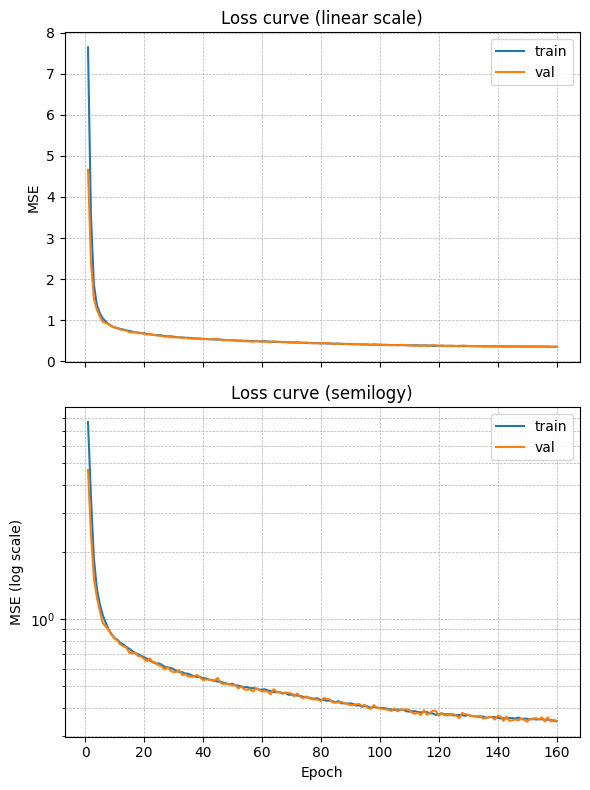

In [90]:
history2 = myNN2.fit(
    train_ds2.batch(batch_size),
    validation_data=val_ds2.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
myNN2.summary()
plot_loss(history2)

In [91]:
def average_relative_error2(model: tf.keras.Model,
                           batchsize: int,
                           no_tests: int,
                           mc_samples: int,
                           n_per_sample: int,
                           noise_std: float, ) -> float:
    """Estimate mean relative error with Monte-Carlo dropout."""
    # Simulate a fresh batch
    summaries, theta_true = simulate_batch_spike(
        no_params,
        batch_size=no_tests,
        n_per_sample=n_per_sample,
        noise_std=noise_std,
        zero_prob=0.3
    )  # shapes: (N, ·) and (N, D, 1)
    theta_true_np = np.squeeze(theta_true.numpy(), axis=-1)  # (N, D)

    # Monte-Carlo dropout passes
    preds = [
        model.predict(summaries, batch_size=batchsize, verbose=0)
        for _ in range(mc_samples)
    ]
    theta_pred_mean = tf.reduce_mean(np.stack(preds, axis=0), axis=0)  # (N, D)

    # compute the relative error
    eps = 1e-8
    diff = theta_pred_mean - theta_true_np  # (N, D)
    numer = np.linalg.norm(diff, axis=1)  # ‖θ̂ – θ‖₂
    denom = np.linalg.norm(theta_true_np, axis=1) + eps
    return (numer / denom).mean()


In [92]:
avg_re2 = average_relative_error2(
    model=myNN2,
    batchsize=batch_size,
    no_tests=no_test_samples,
    mc_samples=mc_samples,
    n_per_sample=n_per_sample,
    noise_std=noise_std,
)
print(f"Average relative error (MC-{mc_samples}): {avg_re:.4f}")

Average relative error (MC-50): 0.0587


In [97]:
def plot_single_dataset_posterior2(model: tf.keras.Model,
                                  *,
                                  no_params: int = no_params,
                                  n_per_sample: int = n_per_sample,
                                  noise_std: float = noise_std,
                                  theta_range: tuple = theta_range,
                                  mc_samples: int = mc_samples,
                                  bins: int = 30,
                                  cmap: str = "tab10") -> None:
    """
    One data-set → many MC-dropout draws → θ histograms
    + overlay of the generative Normal(θ_true, σ²) density.
    The x-axis is fixed to [θ_min - 2,  θ_max + 2]
    """
    # simulate a single experiment  also return raw X, y needed to calculate posterior
    summaries, theta_true = simulate_batch_spike(
        no_params=no_params,
        batch_size=1,
        n_per_sample=n_per_sample,
        noise_std=noise_std,
        zero_prob=0.3
    )
    theta_true = theta_true.numpy().squeeze(-1).flatten()

    # MC draws
    preds = [
        model.predict(summaries, verbose=0)[0]  # (D,)
        for _ in range(mc_samples)
    ]
    preds = np.stack(preds, axis=0)  # (K, D)

    # set-up plot
    n_rows, n_cols = 2, 5
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 3, n_rows * 3.5),
        squeeze=False
    )

    # for each θ
    for j in range(n_rows * n_cols):
        r, c = divmod(j, n_cols)
        ax = axes[r, c]
        xmin, xmax = -5, 10
        ax.set_xlim(xmin, xmax)

        if j < no_params:
            # histogram of MC–dropout draws
            ax.hist(
                preds[:, j],
                bins=bins,
                color="lightsteelblue",
                edgecolor="k",
                alpha=0.75,
                density=True
            )
            ax.axvline(  # <- was ax.vertical
                theta_true[j],
                color="limegreen",
                linewidth=2.0,
                label=r"$\theta_{\mathrm{true}}$"
            )

            # aesthetics
            ax.set_title(f"θ{j + 1}")
            if c == 0:
                ax.set_ylabel("density")
            ax.grid(alpha=0.3, linestyle="--")
            ax.legend(fontsize=7)
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

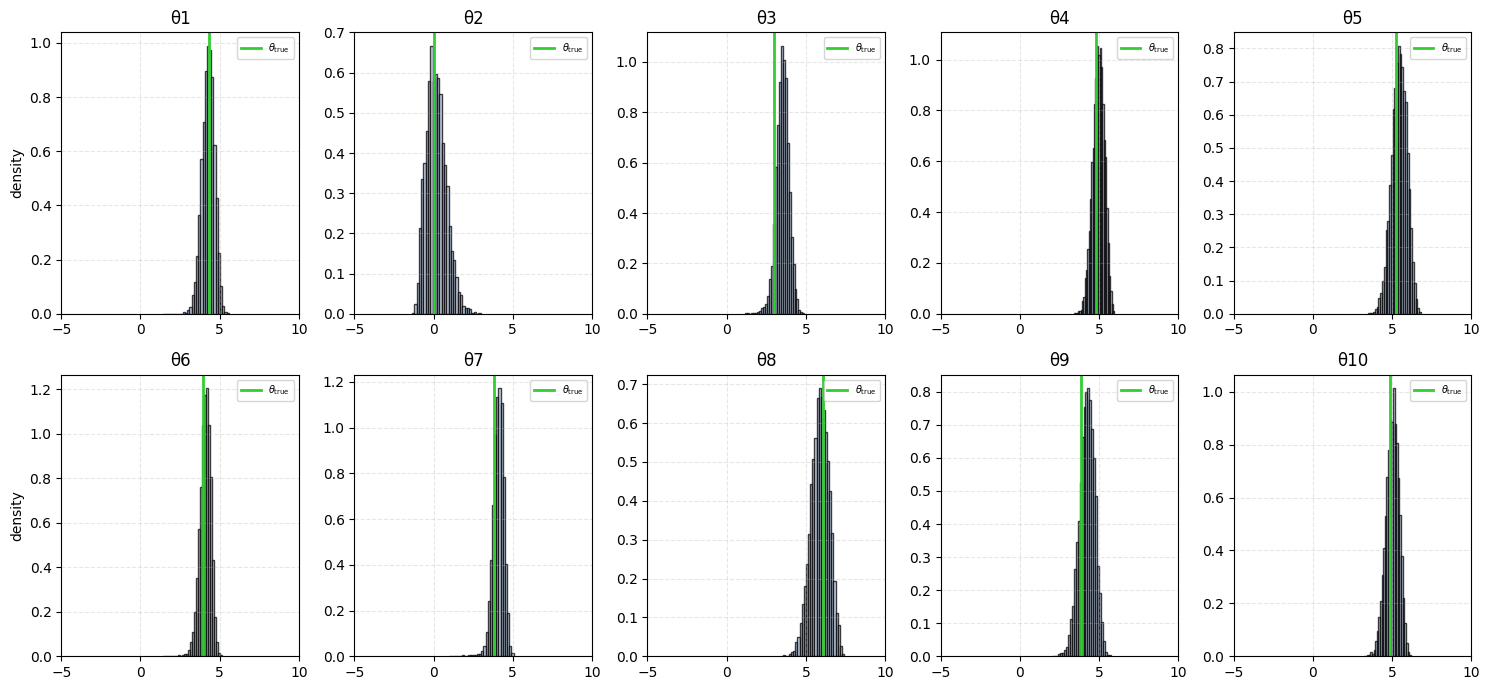

In [98]:
plot_single_dataset_posterior2(model=myNN2, mc_samples=10_000, noise_std=noise_std)